###**Downloading and Unziping the data via kaggle API**

In [7]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'
!kaggle datasets download -d ssismasterchief/machine-hack-fake-news-content-detection # dataset API Command
!unzip machine-hack-fake-news-content-detection.zip

  0% 0.00/560k [00:00<?, ?B/s]
100% 560k/560k [00:00<00:00, 88.0MB/s]
Archive:  machine-hack-fake-news-content-detection.zip
  inflating: Test.csv                
  inflating: Train.csv               
  inflating: sample submission.csv   


## **Importing Libraries**

In [8]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import string
from tqdm import tqdm
tqdm.pandas()

###**Importing the data**

In [9]:
data = pd.read_csv("Train.csv")

###**Explanotary Data Analysis**

In [10]:
data.head()

,Labels,Text,Text_Tag
0,1,Says the Annies List political group supports ...,abortion
1,2,When did the decline of coal start? It started...,"energy,history,job-accomplishments"
2,3,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy
3,1,Health care reform legislation is likely to ma...,health-care
4,2,The economic turnaround started at the end of ...,"economy,jobs"


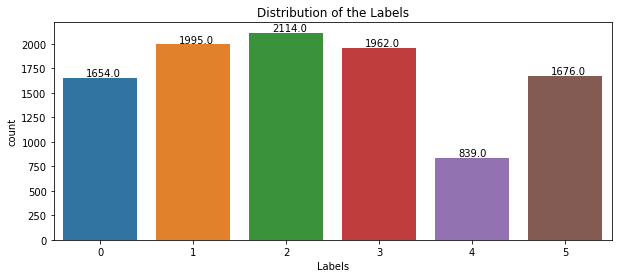

In [11]:
plt.figure(figsize = (10,4))
ax = sns.countplot(x="Labels", data=data)
for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+15))
plt.title("Distribution of the Labels")
plt.show()

###**Pre-Processing the Data**

In [21]:
data['Original Text'] = data['Text']
data["Text"] = data["Text"].str.lower()

In [22]:
stopwords_ = set(stopwords.words('english'))

def stopwords_removal(text):
    return " ".join([word for word in str(text).split() if word not in stopwords_])

tqdm.pandas()
data['Text'] = data['Text'].progress_apply(lambda text: stopwords_removal(text))

100%|██████████| 10240/10240 [00:00<00:00, 147025.99it/s]


In [24]:
print(data['Text'][9])

says gop primary opponents glenn grothman joe leibham cast compromise vote cost $788 million higher electricity costs.


In [25]:
punctuations= list(string.punctuation)

def cleaning_punctuations(text):
    return text.translate(str.maketrans('', '', string.punctuation))

data['Text'] = data['Text'].progress_apply(lambda text: cleaning_punctuations(text))

100%|██████████| 10240/10240 [00:00<00:00, 168513.36it/s]


In [26]:
print(data['Text'][9])

says gop primary opponents glenn grothman joe leibham cast compromise vote cost 788 million higher electricity costs


###**Creating Word Cloud for Fake News**

In [19]:
from wordcloud import WordCloud 

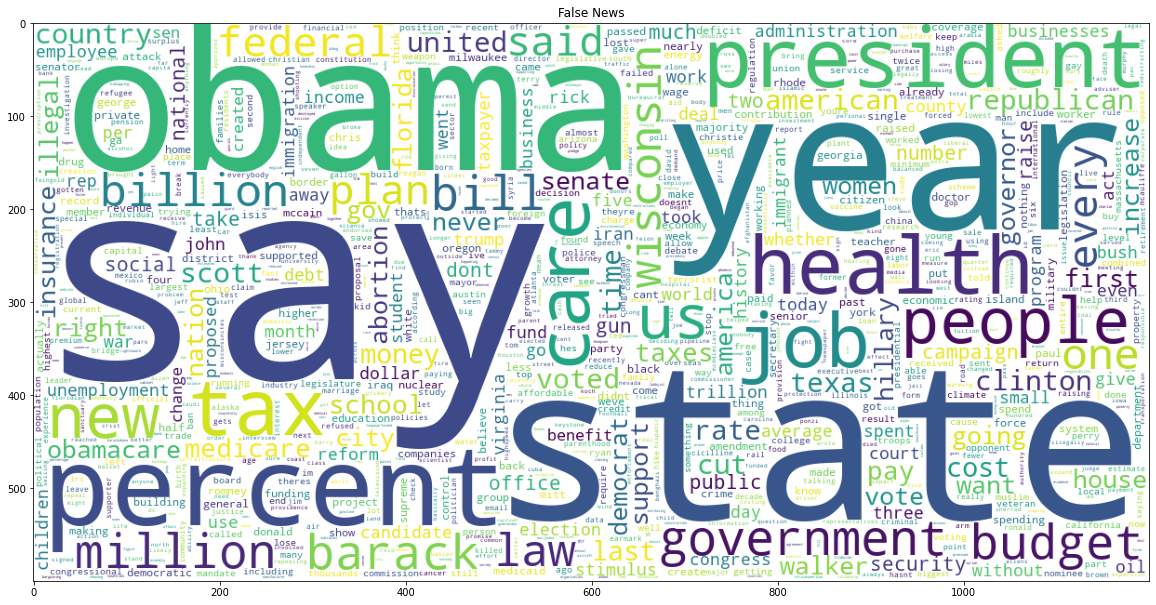

In [27]:
wc = WordCloud(background_color='white', max_words = 1000 , width = 1200 , height = 600, 
               collocations=False).generate(" ".join(data[data['Labels']==1]['Text']))
plt.figure(figsize = (20,20))
plt.title("False News")
plt.imshow(wc)

In [29]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.2 MB/s 


###**Preparing Data for Modeling**

In [30]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa

In [32]:
no_classes = (data['Labels'].nunique())

In [33]:
X = data['Text']
y = tf.keras.utils.to_categorical(data['Labels'], no_classes)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [35]:
train_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>')
train_tokenizer.fit_on_texts(X_train.values)
train_word_index = train_tokenizer.word_index

In [36]:
train_tokenizer

In [37]:
vocab_length = len(train_word_index) + 1
vocab_length

12050

In [38]:
train_sequences = train_tokenizer.texts_to_sequences(X_train)
len(train_sequences)

8192

In [39]:
test_sequences = train_tokenizer.texts_to_sequences(X_test)
len(test_sequences)

2048

In [40]:
maxlen=20
train_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, padding='post', maxlen=maxlen, truncating='post')
test_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, padding='post', maxlen=maxlen, truncating='post')

###**RNN Model**

In [50]:
embedding_dim = 6
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, embedding_dim, input_length=maxlen),
    tf.keras.layers.SimpleRNN(64, activation='tanh', return_sequences=True),
    tf.keras.layers.SimpleRNN(32, activation='tanh', return_sequences=True),
    tf.keras.layers.SimpleRNN(16, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(no_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=tfa.metrics.F1Score(num_classes=num_classes))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 6)             72300     
                                                                 
 simple_rnn (SimpleRNN)      (None, 20, 64)            4544      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20, 32)            3104      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 16)                784       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 6)                 1

In [51]:
history = model.fit(train_padded_seqeunces, y_train, epochs=20, validation_data=(test_padded_seqeunces, y_test))

Epoch 1/20
256/256 [==============================] - 10s 25ms/step - loss: 1.7726 - f1_score: 0.1281 - val_loss: 1.7637 - val_f1_score: 0.1085
Epoch 2/20
256/256 [==============================] - 5s 20ms/step - loss: 1.7419 - f1_score: 0.1824 - val_loss: 1.7732 - val_f1_score: 0.1405
Epoch 3/20
256/256 [==============================] - 6s 25ms/step - loss: 1.6567 - f1_score: 0.2651 - val_loss: 1.8156 - val_f1_score: 0.1558
Epoch 4/20
256/256 [==============================] - 7s 28ms/step - loss: 1.4753 - f1_score: 0.3918 - val_loss: 1.9473 - val_f1_score: 0.1871
Epoch 5/20
256/256 [==============================] - 6s 25ms/step - loss: 1.2220 - f1_score: 0.5257 - val_loss: 2.1483 - val_f1_score: 0.1794
Epoch 6/20
256/256 [==============================] - 5s 20ms/step - loss: 0.9697 - f1_score: 0.6501 - val_loss: 2.4051 - val_f1_score: 0.1957
Epoch 7/20
256/256 [==============================] - 9s 37ms/step - loss: 0.7750 - f1_score: 0.7253 - val_loss: 2.7257 - val_f1_score: 0.183

In [52]:
model.evaluate(test_padded_seqeunces, y_test)

64/64 [==============================] - 0s 6ms/step - loss: 4.8720 - f1_score: 0.1841


[4.87195348739624,
 array([0.1508876 , 0.20624152, 0.21822542, 0.22800495, 0.11801243,
        0.18333334], dtype=float32)]

In [53]:
test_prob = model.predict(test_padded_seqeunces)
test_pred = np.where(test_prob > 0.5, 1, 0)

64/64 [==============================] - 1s 6ms/step


###**Calcualting the Performance of the Model**

In [54]:
from sklearn.metrics import f1_score, log_loss, multilabel_confusion_matrix, plot_confusion_matrix

In [55]:
print("Log-Loss =", log_loss(y_test, test_prob))

Log-Loss = 4.871953209343729


In [56]:
print("F1-Score =", f1_score(y_test, test_pred, average = 'weighted'))

F1-Score = 0.18500949242144135


In [57]:
labels = ['Barely-True', 'False', 'Half-True', 'Mostly-True', 'Not-Known', 'True']
cm = multilabel_confusion_matrix(y_test, test_pred)

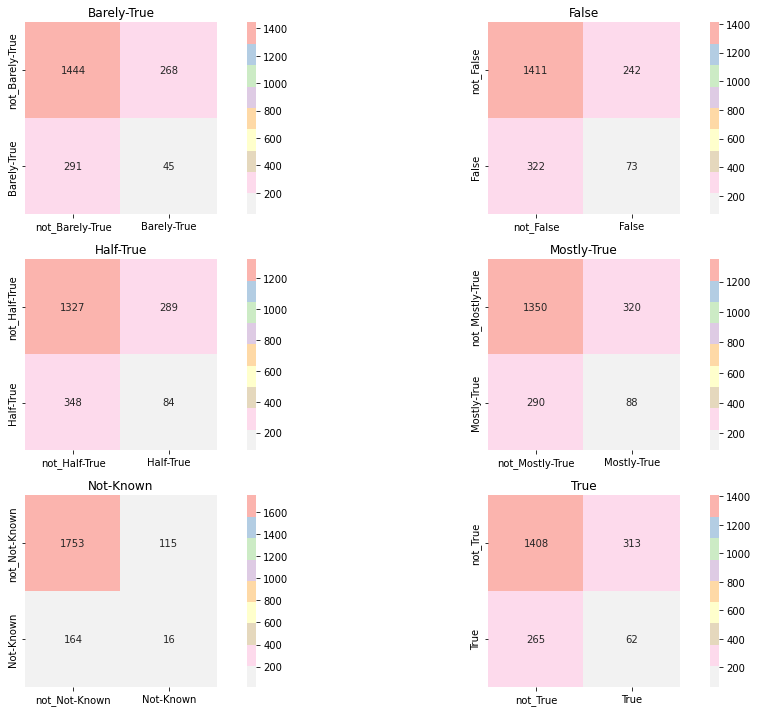

In [58]:
fig = plt.figure(figsize = (15, 10))
for i, (label, matrix) in enumerate(zip(labels, cm)):
    plt.subplot(3, 2, i+1)
    l = [f'not_{label}', label]
    sns.heatmap(matrix, annot = True, square = True, xticklabels = l, yticklabels = l, cmap='Pastel1_r', fmt='d')
    plt.title(label)
    
plt.tight_layout()
plt.show()